In [1]:
import os,sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Looking at real data of pneumonia x-ray images used with CNNs. Data from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
# Data includes bacterial and viral pneumonia = the firal version being critical to development of COVID19
# These are grayscale images!

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12829245113146345140, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11210582808877726167
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9958612993848166656
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7298761376
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4694468484967934487
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set working directory
dir = '/content/drive/MyDrive/chest_xray'

In [6]:
os.listdir(dir)

['.DS_Store', 'test', 'val', 'train']

In [7]:
# Outlining the training/test/val

test_dir = dir+'/test/'
train_dir = dir+'/train/'
val_dir = dir+'/val/'

In [8]:
os.listdir(train_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [9]:
os.listdir(test_dir)

['NORMAL', 'PNEUMONIA']

In [10]:
os.listdir(val_dir)

['PNEUMONIA', 'NORMAL']

In [11]:
# Lables are PNEUMONIA and NORMAL

In [12]:
# Looking at single image
os.listdir(train_dir+'PNEUMONIA')[404]

'person658_virus_1241.jpeg'

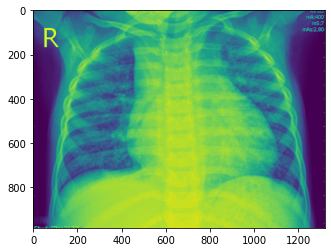

In [13]:
pneumonic_lung = train_dir+'PNEUMONIA/'+'person1293_virus_2219.jpeg'
plt.imshow(imread(pneumonic_lung))

In [14]:
# Looking at single image
os.listdir(train_dir+'NORMAL')[404]

'NORMAL2-IM-0587-0001-0002.jpeg'

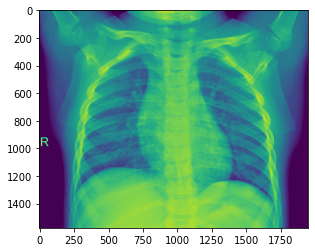

In [15]:
non_pneumonic_lung = train_dir+'NORMAL/'+'IM-0469-0001.jpeg'
plt.imshow(imread(non_pneumonic_lung))

In [16]:
# Can see difference between pneumonic and normal lung -> pneumonia shows a cloudy-like structure in the lungs

In [17]:
# Looking at shapes

imread(pneumonic_lung).shape

(984, 1320)

In [18]:
# Looking at shapes

imread(non_pneumonic_lung).shape

(1576, 1948)

In [19]:
# Finding numbers
len(os.listdir(train_dir+'NORMAL'))

1341

In [20]:
len(os.listdir(train_dir+'PNEUMONIA'))

3881

In [21]:
len(os.listdir(test_dir+'NORMAL'))

234

In [22]:
len(os.listdir(test_dir+'PNEUMONIA'))

390

In [23]:
len(os.listdir(val_dir+'NORMAL'))

8

In [24]:
len(os.listdir(val_dir+'PNEUMONIA'))

8

In [25]:
# Greater number of pneumoic images for train and test sets, while only 8 for each in validation set

In [26]:
'''# All images are a different size!
x_dim = []
y_dim = []

for image_file in os.listdir(train_dir+'NORMAL'):
    img = imread(train_dir+'NORMAL/'+image_file)
    x_dims, y_dims = img.shape
    x_dim.append(x_dims)
    y_dim.append(y_dims)'''

"# All images are a different size!\nx_dim = []\ny_dim = []\n\nfor image_file in os.listdir(train_dir+'NORMAL'):\n    img = imread(train_dir+'NORMAL/'+image_file)\n    x_dims, y_dims = img.shape\n    x_dim.append(x_dims)\n    y_dim.append(y_dims)"

In [27]:
# Looking at historgame of image dimensions
#sns.jointplot(x=x_dim, y = y_dim)

In [28]:
# Resize all images to make them same size. Will choose average size whhc is around 131x131
#print(np.mean(x_dim), np.mean(y_dim))


In [29]:
# Will use 1280 x 1280 -> around mean size (or 360,360)
image_shape = (200,200)

In [30]:
# Data processing - this model will have batch processing -> images are rather large. Will also add random rotations etc

train_datagen = ImageDataGenerator(rotation_range = 90,
                                 width_shift_range=0.5,
                                 height_shift_range=0.5,
                                 rescale = 1./255,
                                 shear_range=0.5,
                                 zoom_range=0.5,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='nearest',)

test_datagen = ImageDataGenerator(rescale = 1./255) 

In [31]:
# Defining data generators for feeding from directory to the CNN in batches

train_generator  = train_datagen.flow_from_directory(
                             train_dir,
                             target_size = image_shape,
                             batch_size =16,               
                             class_mode = 'binary',
                            )

test_generator = test_datagen.flow_from_directory(
                             test_dir,
                             target_size = image_shape,
                             batch_size = 16,               
                             class_mode = 'binary',
                            )

validation_generator = test_datagen.flow_from_directory(
                             val_dir,
                             target_size = image_shape,
                             batch_size = 16,               
                             class_mode = 'binary',
                            )

Found 5222 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [36]:
# Model definition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from datetime import datetime
from tensorflow.keras.optimizers import Adam, SGD, Adagrad

opt = tf.keras.optimizers.Adagrad(learning_rate=0.0001)

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3), input_shape = (200,200,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (200,200,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = (200,200,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3), input_shape = (200,200,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3), input_shape = (200,200,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (3,3), input_shape = (200,200,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])



model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 99, 99, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 99, 99, 16)        64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 64)       

In [37]:
# Geting tensorboard set up

timestamp = datetime.now().strftime("%d/%m/%Y, %H:%M:%S")

# Define TBoard and directory

log_directory = 'logs/fit'
log_directory = log_directory+'/'+timestamp

board = TensorBoard(log_dir = log_directory,
                   histogram_freq = 1,
                   write_graph = True,
                   write_images = True,
                   update_freq = 'epoch',
                   profile_batch = 2,
                   embeddings_freq = 1)

In [38]:
# Define early call backs

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, mode='min')

In [39]:
# Final model

final_model = model.fit(train_generator,
              epochs=50,
              validation_data=test_generator, 
              callbacks=[lr_reduce,board,early_stop],
              )

Epoch 1/50
327/327 [==============================] - 1743s 5s/step - loss: 0.5367 - accuracy: 0.7338 - val_loss: 1.0006 - val_accuracy: 0.6250
Epoch 2/50
327/327 [==============================] - 101s 308ms/step - loss: 0.4702 - accuracy: 0.7706 - val_loss: 0.4818 - val_accuracy: 0.7276
Epoch 3/50
327/327 [==============================] - ETA: 0s - loss: 0.4670 - accuracy: 0.7675
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
327/327 [==============================] - 101s 310ms/step - loss: 0.4670 - accuracy: 0.7675 - val_loss: 0.4419 - val_accuracy: 0.7965
Epoch 4/50
327/327 [==============================] - 101s 308ms/step - loss: 0.4344 - accuracy: 0.7874 - val_loss: 0.4526 - val_accuracy: 0.7837
Epoch 5/50
327/327 [==============================] - ETA: 0s - loss: 0.4385 - accuracy: 0.7871
Epoch 00005: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
327/327 [==============================] - 101s 308ms/step - loss: 0.4385 - 

In [40]:
losses = pd.DataFrame(model.history.history)

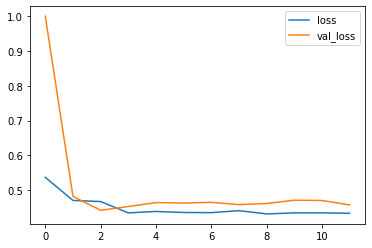

In [41]:
losses[['loss','val_loss']].plot()

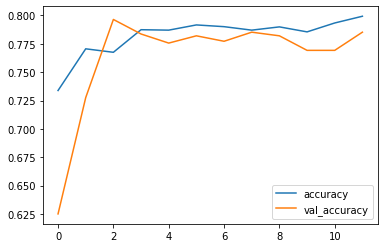

In [42]:
losses[['accuracy','val_accuracy']].plot()

In [ ]:
# Saving model

from tensorflow.keras.models import load_model
model.save('pneumonia_cnn.h5')

In [ ]:
ls

In [ ]:
# Evaluating...
model.evaluate_generator(test_generator)

In [ ]:
model.metrics_names

In [ ]:
# Predicting
preds = model.predict(test_generator)

In [ ]:
# Getting predictions with over 50% sureness
# Can increase this value - i.e only 90% sure 
predictions = preds > 0.5

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_generator.classes,predictions))
print(confusion_matrix(test_generator.classes,predictions))

In [ ]:
test_accuracy = model.evaluate_generator(test_generator,steps=624)
print('The testing accuracy is :',test_accuracy[1]*100, '%')

In [ ]:
Y_pred = model.predict(test_generator, 100)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
y_pred

In [ ]:
max(y_pred)